<a href="https://colab.research.google.com/github/LonnieSly/Dynamic_Pricing_Optimization/blob/main/Dynamic_Pricing_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Config
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
# Load the CSV
df = pd.read_csv('hotel_bookings.csv')  # Adjust if your file is named differently
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
# Shape and columns
print("Shape:", df.shape)
df.info()

# Preview missing values
df.isnull().sum().sort_values(ascending=False).head(10)


Shape: (119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 

,0
company,112593
agent,16340
country,488
children,4
arrival_date_month,0
arrival_date_week_number,0
hotel,0
is_canceled,0
stays_in_weekend_nights,0
arrival_date_day_of_month,0


In [ ]:
# Fill missing children values with 0
df['children'].fillna(0, inplace=True)

# Drop company and agent for now (too many missing values)
df.drop(['company', 'agent'], axis=1, inplace=True)

# Drop rows with missing country (optional)
df.dropna(subset=['country'], inplace=True)


/tmp/ipython-input-4-4027455563.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)


**Create New Features**
*These will help improve our model’s ability to capture seasonality and guest behavior:*

In [ ]:
# Convert to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Create stay duration
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Extract temporal features
df['year'] = df['reservation_status_date'].dt.year
df['month'] = df['reservation_status_date'].dt.month
df['day_of_week'] = df['reservation_status_date'].dt.dayofweek

# Add total guests
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# Encode hotel type as binary
df['is_resort'] = df['hotel'].apply(lambda x: 1 if x == 'Resort Hotel' else 0)


 **Exploratory Data Analysis**

 **Explore ADR Patterns**
 *Helps validate that pricing varies seasonally and by number of guests*

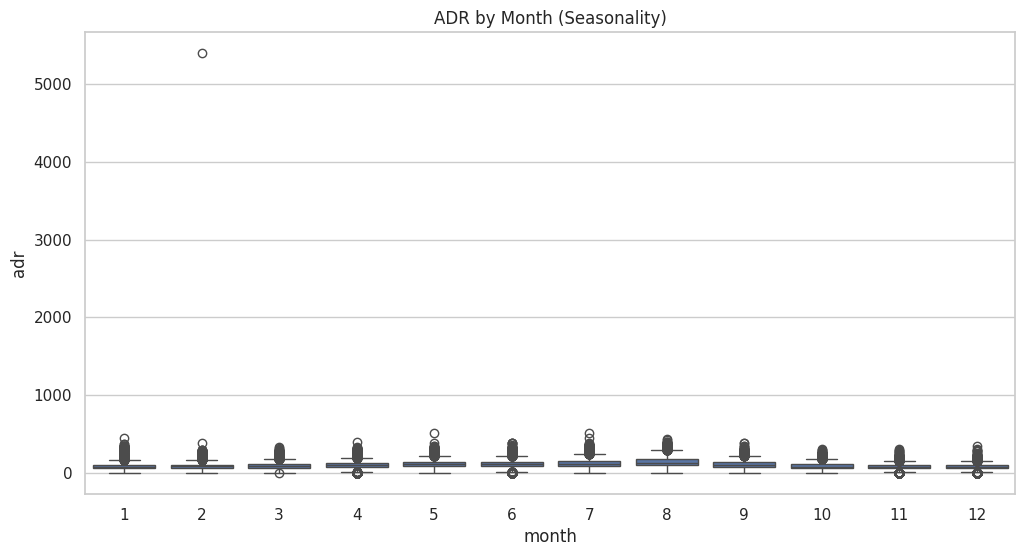

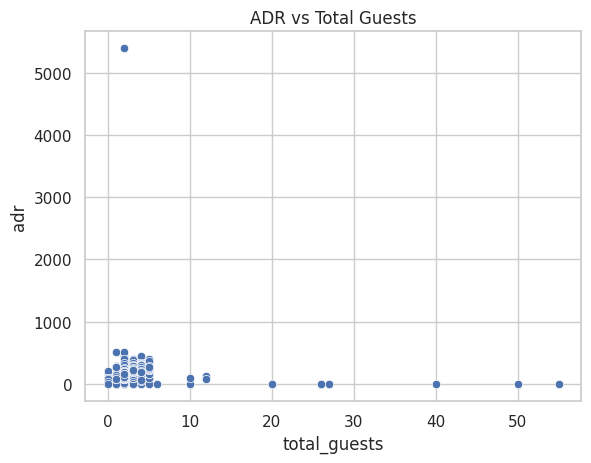

In [ ]:
# Average ADR by month
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='adr', data=df)
plt.title("ADR by Month (Seasonality)")
plt.show()

# ADR vs total guests
sns.scatterplot(x='total_guests', y='adr', data=df)
plt.title("ADR vs Total Guests")
plt.show()


**Machine Learning Model for Pricing**
*Prepare Data for Modeling*

In [ ]:
# Feature set
features = [
    'lead_time', 'total_guests', 'is_canceled', 'previous_cancellations',
    'booking_changes', 'days_in_waiting_list', 'total_of_special_requests',
    'month', 'day_of_week', 'total_nights', 'is_resort'
]

X = df[features]
y = df['adr']


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 1912.2945585836555
R² Score: 0.1675169207425573


 **Price Optimization Insights**
 Now we can identify:

Optimal pricing patterns by season or guest type

How much special requests, booking changes, or lead time impact rates *italicized text*

In [ ]:
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

coef_df

#  Great for storytelling in Looker Studio or your GitHub README.


,Feature,Coefficient
1,total_guests,25.479829
2,is_canceled,9.320642
6,total_of_special_requests,7.635281
4,booking_changes,2.131638
9,total_nights,1.179274
8,day_of_week,0.481222
7,month,0.289953
5,days_in_waiting_list,-0.039007
0,lead_time,-0.055119
3,previous_cancellations,-2.965046


*The above model under performed so I will train another.*

 **Add Strong Categorical Features**
*Will use one-hot encoding on selected high-impact columns:*

In [ ]:
# Add categorical features to your feature set
categorical = ['market_segment', 'distribution_channel', 'deposit_type', 'customer_type', 'reserved_room_type']
df_encoded = pd.get_dummies(df[categorical], drop_first=True)

# Combine with numerical features
numerical = [
    'lead_time', 'total_guests', 'is_canceled', 'previous_cancellations',
    'booking_changes', 'days_in_waiting_list', 'total_of_special_requests',
    'month', 'day_of_week', 'total_nights', 'is_resort'
]

X = pd.concat([df[numerical], df_encoded], axis=1)
y = df['adr']


In [ ]:
# Filter out outliers beyond 500 ADR
df = df[df['adr'] < 500]


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 871.8049839624558
R² Score: 0.620475363325518


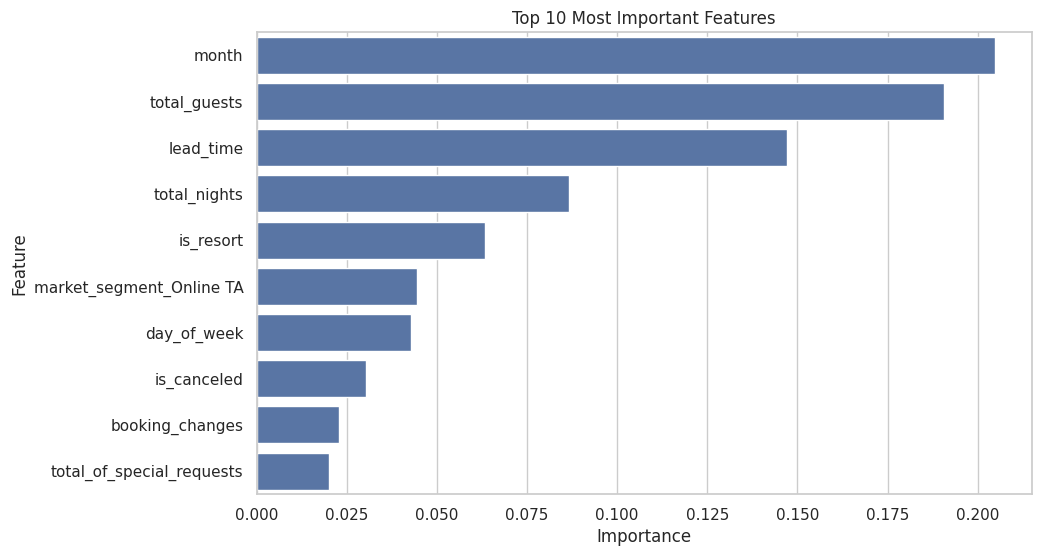

In [ ]:
# Check Feature Importance

importances = rf.feature_importances_
feature_names = X.columns

# Create a feature importance plot
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()


In [ ]:
# A manually tuned version (faster)
rf_tuned = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("Tuned MSE:", mean_squared_error(y_test, y_pred))
print("Tuned R²:", r2_score(y_test, y_pred))

Tuned MSE: 627.0799811928473
Tuned R²: 0.7270119964830284


In [ ]:
# Use RandomizedSearchCV

# Define distribution of parameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5, 10]
}

rsearch = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,  # Try only 10 random combinations
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

rsearch.fit(X_train, y_train)
best_model = rsearch.best_estimator_

y_pred = best_model.predict(X_test)
print("RandomSearch MSE:", mean_squared_error(y_test, y_pred))
print("RandomSearch R²:", r2_score(y_test, y_pred))


RandomSearch MSE: 614.3521159699847
RandomSearch R²: 0.7325528439353948


**Save Predictions for Dashboarding**
*save actual vs. predicted ADR, and include some key features (month, hotel, guests, etc.).*

In [ ]:
# Reset index to align for merge
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
df = df.reset_index(drop=True)


# Rebuild the results DataFrame
results_df = X_test.copy()
results_df['actual_adr'] = y_test
results_df['predicted_adr'] = y_pred

# Add back original context from the main df
results_df['reservation_status_date'] = df.loc[y_test.index, 'reservation_status_date'].values
results_df['hotel'] = df.loc[y_test.index, 'hotel'].values
results_df['market_segment'] = df.loc[y_test.index, 'market_segment'].values

# Optional: Round predictions
results_df['predicted_adr'] = results_df['predicted_adr'].round(2)
results_df['actual_adr'] = results_df['actual_adr'].round(2)

# Save as CSV
results_df.to_csv('adr_predictions.csv', index=False)


# now have I a ready-to-upload CSV for BigQuery or Looker Studio.


In [ ]:
print(results_df.head())


   lead_time  total_guests  is_canceled  previous_cancellations  \
0         10           1.0            0                       0   
1          2           2.0            0                       0   
2        168           4.0            0                       0   
3         71           2.0            0                       0   
4        206           2.0            1                       0   

   booking_changes  days_in_waiting_list  total_of_special_requests  month  \
0                0                     0                          0      6   
1                0                     0                          0     12   
2                0                     0                          0      8   
3                1                     0                          0      5   
4                0                     0                          0      5   

   day_of_week  total_nights  ...  reserved_room_type_F  reserved_room_type_G  \
0            1             1  ...              